In [27]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
#import shutil
from sklearn.preprocessing import MinMaxScaler
#from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mse
#from darts.utils.statistics import check_seasonality, plot_acf
#from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import forecasting
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

In [92]:
import yfinance as yf

In [93]:
import yfinance as yf
aapl= yf.Ticker("aapl")
df = aapl.history(start="2022-04-01", end="2023-04-01", interval="1d")

# data.reset_index(inplace=True)
# data = data[['Date', 'Close']]

idx = pd.date_range(start='2022-04-01', end='2023-04-01')
df.index = pd.DatetimeIndex(df.index)
df.index = df.index.tz_localize(None) 
# # #df['Date'] = pd.to_datetime(df['Date'])
# # #print(df)
# # #df.set_index='Date'
# # #print(df)
# # df.index = pd.DatetimeIndex(df.index)
# # print(df)
df = df.reindex(idx, method = 'pad')
print(df)

                  Open        High         Low       Close    Volume  \
2022-04-01  172.982124  173.827012  170.904712  173.260437  78751300   
2022-04-02  172.982124  173.827012  170.904712  173.260437  78751300   
2022-04-03  172.982124  173.827012  170.904712  173.260437  78751300   
2022-04-04  173.518892  177.415287  173.389670  177.365585  76468400   
2022-04-05  176.431231  177.226417  173.369775  174.005920  73401800   
...                ...         ...         ...         ...       ...   
2023-03-28  157.970001  158.490005  155.979996  157.649994  45992200   
2023-03-29  159.369995  161.050003  159.350006  160.770004  51305700   
2023-03-30  161.529999  162.470001  161.270004  162.360001  49501700   
2023-03-31  162.440002  165.000000  161.910004  164.899994  68749800   
2023-04-01  162.440002  165.000000  161.910004  164.899994  68749800   

            Dividends  Stock Splits  
2022-04-01        0.0           0.0  
2022-04-02        0.0           0.0  
2022-04-03        0.0

In [94]:
series = TimeSeries.from_dataframe(df)
print(series)

<TimeSeries (DataArray) (time: 366, component: 7, sample: 1)>
array([[[1.72982124e+02],
        [1.73827012e+02],
        [1.70904712e+02],
        ...,
        [7.87513000e+07],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.72982124e+02],
        [1.73827012e+02],
        [1.70904712e+02],
        ...,
        [7.87513000e+07],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.72982124e+02],
        [1.73827012e+02],
        [1.70904712e+02],
        ...,
...
        ...,
        [4.95017000e+07],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.62440002e+02],
        [1.65000000e+02],
        [1.61910004e+02],
        ...,
        [6.87498000e+07],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.62440002e+02],
        [1.65000000e+02],
        [1.61910004e+02],
        ...,
        [6.87498000e+07],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-

<TimeSeries (DataArray) (time: 293, component: 1, sample: 1)>
array([[[9.21860557e-01]],

       [[9.21860557e-01]],

       [[9.21860557e-01]],

       [[1.00000000e+00]],

       [[9.36050460e-01]],

       [[8.74939134e-01]],

       [[8.80804348e-01]],

       [[8.42018535e-01]],

       [[8.42018535e-01]],

       [[8.42018535e-01]],

...

       [[9.74982221e-02]],

       [[1.08521421e-01]],

       [[1.60976662e-01]],

       [[1.59456191e-01]],

       [[1.85113381e-01]],

       [[1.85113381e-01]],

       [[1.85113381e-01]],

       [[1.85113381e-01]],

       [[2.07539969e-01]],

       [[1.93666068e-01]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-01-18
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 73, component: 1, sample: 1)>
array([[[0.19480635]],

       [[0.24422036]],

       [[0.24422036]],

  

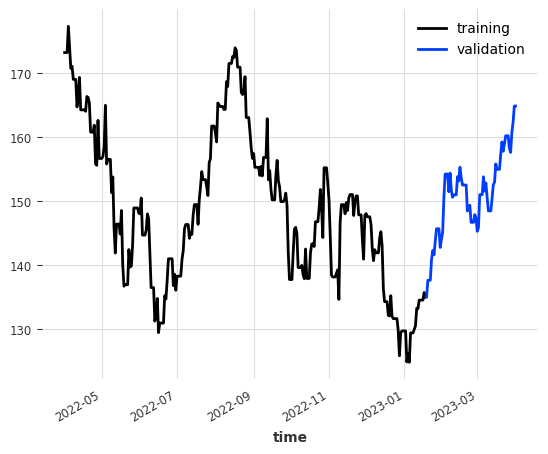

In [95]:
adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
training, validation = adj_series.split_after(0.8)
training.plot(label='training')
validation.plot(label='validation')
plt.legend();
from darts.dataprocessing.transformers import Scaler
transformer = Scaler()
train_transformed = transformer.fit_transform(training)
val_transformed = transformer.transform(validation)
series_transformed = transformer.transform(adj_series)
print(train_transformed)
print(val_transformed)
print(series_transformed)
# scaler_stock = Scaler()
# series_stock_scaled = scaler_stock.fit_transform(adj_series)
# print(series_stock_scaled)
# training, validation = adj_series.split_after(0.8)

In [34]:
# training, validation = series_stock_scaled.split_after(0.8)

In [108]:
my_model = RNNModel(
    model="LSTM",
    n_rnn_layers = 3,
    hidden_dim=4,
    dropout=0,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=3,
    force_reset=True,
    save_checkpoints=True,
)
my_model.fit(train_transformed)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=4, n_rnn_layers=3, dropout=0, training_length=20, batch_size=16, n_epochs=10, optimizer_kwargs={'lr': 0.001}, model_name=Air_RNN, log_tensorboard=True, random_state=42, input_chunk_length=3, force_reset=True, save_checkpoints=True)

In [109]:
pred = my_model.predict(n=len(val_transformed))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 19.56%


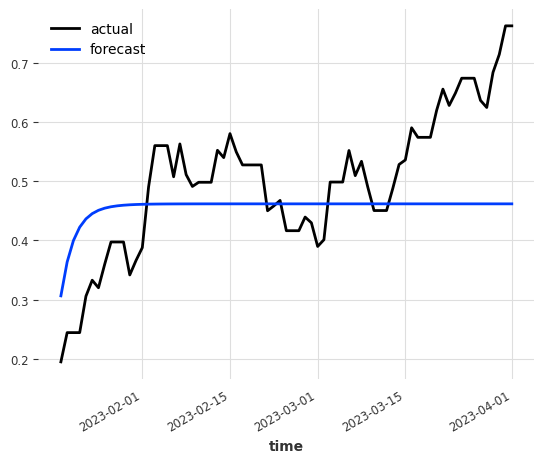

In [110]:
val_transformed.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))

MAPE = 19.56%


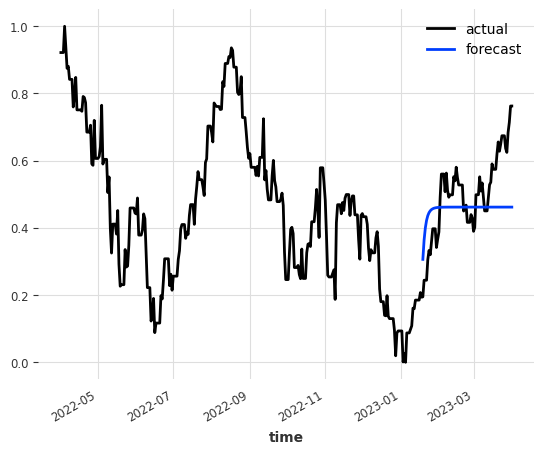

In [111]:
series_transformed.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_transformed, pred)))

In [112]:
inverse_scaler_pred = transformer.inverse_transform(pred)


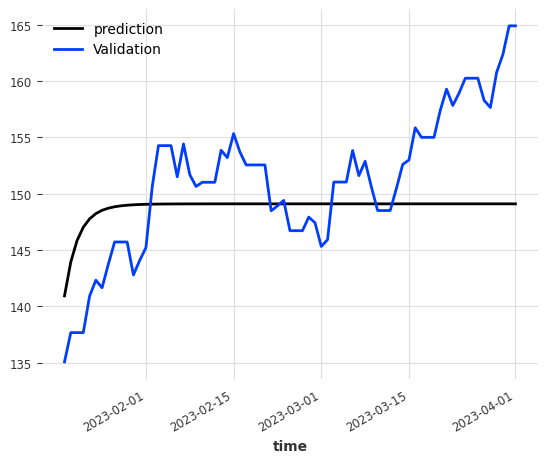

In [113]:
inverse_scaler_pred = transformer.inverse_transform(pred)

inverse_scaler_pred.plot(label='prediction')
validation.plot(label='Validation')
plt.legend();

In [41]:
# rescaled_pred = scalar().inverse_transform(pred)

# series_stock_rescaled = scaler_stock.inverse_transform(pred)
# plt.plot(series_stock_rescaled)

In [42]:
# series_stock_rescaled_original_series = scaler_stock.inverse_transform(adj_series)
# series_stock_rescaled_validation_series = scaler_stock.inverse_transform(validation)

# series_stock_rescaled_original_series.plot(label='actual')
# series_stock_rescaled.plot(label='forecast')
# plt.legend();
# print('MAPE = {:.2f}%'.format(mape(series_stock_scaled, pred)))

In [47]:
!pip install optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00


In [107]:
import optuna
from sklearn.model_selection import cross_val_score


def objective(trial):

    n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 5)
    hidden_dim = trial.suggest_int("hidden_dim", 1, 5)
    input_chunk_length = trial.suggest_int("input_chunk_length", 1,5)

    my_model = RNNModel(
    model="LSTM",
    n_rnn_layers = n_rnn_layers,
    hidden_dim= hidden_dim,
    input_chunk_length=input_chunk_length
    )

    my_model.fit(training)

    preds = my_model.predict(series=training, n=len(validation))
    mapes = mape(validation, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(mapes)

    return smape_val if smape_val != np.nan else float("inf")


def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5, callbacks=[print_callback])




[I 2023-05-06 20:02:22,895] A new study created in memory with name: no-name-531c339a-fce5-4129-ba90-c46cb7b0649e
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 72    
4 | V             | Linear           | 4     
---------------------------------------------------
76        Trainable params
0         Non-trainable params
76        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 491.65it/s]
[I 2023-05-06 20:02:53,597] Trial 0 finished with value: 99.07897941600272 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 3, 'input_chunk_length': 5}. Best is trial 0 with value: 99.07897941600272.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 64    
4 | V             | Linear           | 2     
---------------------------------------------------
66   

Current value: 99.07897941600272, Current params: {'n_rnn_layers': 1, 'hidden_dim': 3, 'input_chunk_length': 5}
Best value: 99.07897941600272, Best params: {'n_rnn_layers': 1, 'hidden_dim': 3, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 473.61it/s]
[I 2023-05-06 20:03:40,355] Trial 1 finished with value: 98.19762490440796 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 5}. Best is trial 1 with value: 98.19762490440796.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 16    
4 | V             | Linear           | 2     
---------------------------------------------------
18   

Current value: 98.19762490440796, Current params: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 5}
Best value: 98.19762490440796, Best params: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 464.74it/s]
[I 2023-05-06 20:04:10,034] Trial 2 finished with value: 99.26770529412397 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 1, 'input_chunk_length': 3}. Best is trial 1 with value: 98.19762490440796.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437  

Current value: 99.26770529412397, Current params: {'n_rnn_layers': 1, 'hidden_dim': 1, 'input_chunk_length': 3}
Best value: 98.19762490440796, Best params: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 410.44it/s]
[I 2023-05-06 20:04:51,346] Trial 3 finished with value: 95.87827216811637 and parameters: {'n_rnn_layers': 3, 'hidden_dim': 4, 'input_chunk_length': 3}. Best is trial 3 with value: 95.87827216811637.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 40    
4 | V             | Linear           | 3     
---------------------------------------------------
43   

Current value: 95.87827216811637, Current params: {'n_rnn_layers': 3, 'hidden_dim': 4, 'input_chunk_length': 3}
Best value: 95.87827216811637, Best params: {'n_rnn_layers': 3, 'hidden_dim': 4, 'input_chunk_length': 3}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 639.08it/s]
[I 2023-05-06 20:05:18,484] Trial 4 finished with value: 99.36039842545625 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 2, 'input_chunk_length': 1}. Best is trial 3 with value: 95.87827216811637.


Current value: 99.36039842545625, Current params: {'n_rnn_layers': 1, 'hidden_dim': 2, 'input_chunk_length': 1}
Best value: 95.87827216811637, Best params: {'n_rnn_layers': 3, 'hidden_dim': 4, 'input_chunk_length': 3}


In [1]:
!darts --version

/bin/bash: darts: command not found


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 19.56%
MAPE = 19.56%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


[I 2023-05-06 23:13:37,765] A new study created in memory with name: no-name-0945dcda-a84a-40d8-bdda-858986ddab15
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 32    
4 | V             | Linear           | 2     
---------------------------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17.80it/s]
[I 2023-05-06 23:14:16,332] Trial 0 finished with value: 98.41928500975492 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 1, 'input_chunk_length': 1}. Best is trial 0 with value: 98.41928500975492.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 232   
4 | V             | Linear           | 3     
---------------------------------------------------
235   

Current value: 98.41928500975492, Current params: {'n_rnn_layers': 2, 'hidden_dim': 1, 'input_chunk_length': 1}
Best value: 98.41928500975492, Best params: {'n_rnn_layers': 2, 'hidden_dim': 1, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 698.58it/s]
[I 2023-05-06 23:15:13,876] Trial 1 finished with value: 98.18950952341419 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 2, 'input_chunk_length': 1}. Best is trial 1 with value: 98.18950952341419.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 880   
4 | V             | Linear           | 6     
---------------------------------------------------
886  

Current value: 98.18950952341419, Current params: {'n_rnn_layers': 5, 'hidden_dim': 2, 'input_chunk_length': 1}
Best value: 98.18950952341419, Best params: {'n_rnn_layers': 5, 'hidden_dim': 2, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 447.11it/s]
[I 2023-05-06 23:16:04,701] Trial 2 finished with value: 94.90515189473541 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 5}. Best is trial 2 with value: 94.90515189473541.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 40    
4 | V             | Linear           | 3     
---------------------------------------------------
43   

Current value: 94.90515189473541, Current params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 5}
Best value: 94.90515189473541, Best params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 593.84it/s]
[I 2023-05-06 23:16:34,185] Trial 3 finished with value: 98.81261152294896 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 2, 'input_chunk_length': 4}. Best is trial 2 with value: 94.90515189473541.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 64    
4 | V             | Linear           | 2     
---------------------------------------------------
66   

Current value: 98.81261152294896, Current params: {'n_rnn_layers': 1, 'hidden_dim': 2, 'input_chunk_length': 4}
Best value: 94.90515189473541, Best params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 561.94it/s]
[I 2023-05-06 23:17:22,563] Trial 4 finished with value: 98.38479186965338 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 5}. Best is trial 2 with value: 94.90515189473541.


Current value: 98.38479186965338, Current params: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 5}
Best value: 94.90515189473541, Best params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 5}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


                  Open        High         Low       Close   Volume  \
2022-04-01  332.230066  334.889154  330.032150  334.241577  2090300   
2022-04-02  332.230066  334.889154  330.032150  334.241577  2090300   
2022-04-03  332.230066  334.889154  330.032150  334.241577  2090300   
2022-04-04  335.566176  338.284164  333.662614  337.999603  2317500   
2022-04-05  335.085402  338.814013  335.085402  336.380615  3058100   
...                ...         ...         ...         ...      ...   
2023-03-28  272.848554  275.079783  271.533710  273.924316  2869400   
2023-03-29  274.920410  279.163757  274.920410  278.845001  2431500   
2023-03-30  279.900841  281.932870  279.681701  281.554352  2293600   
2023-03-31  282.012567  284.841454  281.504552  284.692047  3009300   
2023-04-01  282.012567  284.841454  281.504552  284.692047  3009300   

            Dividends  Stock Splits  
2022-04-01        0.0           0.0  
2022-04-02        0.0           0.0  
2022-04-03        0.0           0

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 320.97%
MAPE = 320.97%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:17:37,212] A new study created in memory with name: no-name-6b62badd-cf1c-4300-b1c2-920937a7578d
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 400   
4 | V             | Linear           | 6     
---------------------------------------------------
406       Trainable params
0         Non-trainable params
406       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 517.75it/s]
[I 2023-05-06 23:18:14,833] Trial 0 finished with value: 97.46630272202415 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 5}. Best is trial 0 with value: 97.46630272202415.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 112   
4 | V             | Linear           | 5     
---------------------------------------------------
117  

Current value: 97.46630272202415, Current params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 5}
Best value: 97.46630272202415, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 764.27it/s]
[I 2023-05-06 23:18:45,827] Trial 1 finished with value: 99.54493780465324 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 4}. Best is trial 0 with value: 97.46630272202415.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 64    
4 | V             | Linear           | 2     
---------------------------------------------------
66   

Current value: 99.54493780465324, Current params: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 4}
Best value: 97.46630272202415, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 385.01it/s]
[I 2023-05-06 23:19:35,974] Trial 2 finished with value: 99.3608922112694 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 1}. Best is trial 0 with value: 97.46630272202415.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.1 K 
4 | V             | Linear           | 6     
---------------------------------------------------
1.1 K 

Current value: 99.3608922112694, Current params: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 1}
Best value: 97.46630272202415, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 707.54it/s]
[I 2023-05-06 23:20:35,812] Trial 3 finished with value: 97.41330751557236 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}. Best is trial 3 with value: 97.41330751557236.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.1 K 
4 | V             | Linear           | 6     
---------------------------------------------------
1.1 K

Current value: 97.41330751557236, Current params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}
Best value: 97.41330751557236, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 483.77it/s]
[I 2023-05-06 23:21:36,891] Trial 4 finished with value: 97.19037626928501 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 5}. Best is trial 4 with value: 97.19037626928501.


Current value: 97.19037626928501, Current params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 5}
Best value: 97.19037626928501, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 5}
                  Open        High         Low       Close   Volume  \
2022-04-01  455.000000  461.549988  450.959991  458.190002  2718400   
2022-04-02  455.000000  461.549988  450.959991  458.190002  2718400   
2022-04-03  455.000000  461.549988  450.959991  458.190002  2718400   
2022-04-04  461.040009  473.489990  460.609985  468.809998  2974500   
2022-04-05  469.320007  471.760010  455.070007  458.579987  2481900   
...                ...         ...         ...         ...      ...   
2023-03-28  373.420013  374.000000  367.820007  373.399994  1780800   
2023-03-29  376.679993  380.119995  375.559998  379.160004  2497600   
2023-03-30  381.649994  382.579987  378.079987  381.899994  2139000   
2023-03-31  382.290009  385.730011  380.260010  385.369995  3063400   
2

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


<TimeSeries (DataArray) (time: 293, component: 1, sample: 1)>
array([[[0.94514748]],

       [[0.94514748]],

       [[0.94514748]],

       [[1.        ]],

       [[0.94716176]],

       [[0.87356018]],

       [[0.9168948 ]],

       [[0.87877691]],

       [[0.87877691]],

       [[0.87877691]],

...

       [[0.34492022]],

       [[0.32797895]],

       [[0.3498269 ]],

       [[0.35814267]],

       [[0.35731624]],

       [[0.35731624]],

       [[0.35731624]],

       [[0.35731624]],

       [[0.35731624]],

       [[0.34145959]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-01-18
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 73, component: 1, sample: 1)>
array([[[0.34776092]],

       [[0.41929652]],

       [[0.41929652]],

       [[0.41929652]],

       [[0.46371575]],

       [[0.44481174]],

       [[0

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 25.08%
MAPE = 25.08%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:21:52,858] A new study created in memory with name: no-name-2e64497c-5b4e-4ad1-b7a8-940c83d6c557
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 592   
4 | V             | Linear           | 5     
---------------------------------------------------
597       Trainable params
0         Non-trainable params
597       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 574.01it/s]
[I 2023-05-06 23:22:45,661] Trial 0 finished with value: 98.4838528078834 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 4, 'input_chunk_length': 3}. Best is trial 0 with value: 98.4838528078834.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 880   
4 | V             | Linear           | 6     
---------------------------------------------------
886    

Current value: 98.4838528078834, Current params: {'n_rnn_layers': 4, 'hidden_dim': 4, 'input_chunk_length': 3}
Best value: 98.4838528078834, Best params: {'n_rnn_layers': 4, 'hidden_dim': 4, 'input_chunk_length': 3}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 307.03it/s]
[I 2023-05-06 23:23:44,098] Trial 1 finished with value: 98.03496859912384 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 4}. Best is trial 1 with value: 98.03496859912384.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 88    
4 | V             | Linear           | 3     
---------------------------------------------------
91   

Current value: 98.03496859912384, Current params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 4}
Best value: 98.03496859912384, Best params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 644.98it/s]
[I 2023-05-06 23:24:22,427] Trial 2 finished with value: 98.92280634030566 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 2, 'input_chunk_length': 2}. Best is trial 1 with value: 98.03496859912384.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 112   
4 | V             | Linear           | 5     
---------------------------------------------------
117  

Current value: 98.92280634030566, Current params: {'n_rnn_layers': 2, 'hidden_dim': 2, 'input_chunk_length': 2}
Best value: 98.03496859912384, Best params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 402.25it/s]
[I 2023-05-06 23:24:51,713] Trial 3 finished with value: 99.77056457054321 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 2}. Best is trial 1 with value: 98.03496859912384.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 32    
4 | V             | Linear           | 2     
---------------------------------------------------
34   

Current value: 99.77056457054321, Current params: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 2}
Best value: 98.03496859912384, Best params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 569.65it/s]
[I 2023-05-06 23:25:29,252] Trial 4 finished with value: 99.194539772013 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 1, 'input_chunk_length': 4}. Best is trial 1 with value: 98.03496859912384.


Current value: 99.194539772013, Current params: {'n_rnn_layers': 2, 'hidden_dim': 1, 'input_chunk_length': 4}
Best value: 98.03496859912384, Best params: {'n_rnn_layers': 4, 'hidden_dim': 5, 'input_chunk_length': 4}
                  Open        High         Low       Close   Volume  \
2022-04-01  163.442967  164.071215  159.859989  162.323898  2941000   
2022-04-02  163.442967  164.071215  159.859989  162.323898  2941000   
2022-04-03  163.442967  164.071215  159.859989  162.323898  2941000   
2022-04-04  162.137387  162.903065  158.750734  161.479691  4159600   
2022-04-05  159.526210  160.507849  153.008125  157.042664  7223600   
...                ...         ...         ...         ...      ...   
2023-03-28  183.720001  184.000000  180.880005  183.600006  3319900   
2023-03-29  186.039993  190.300003  186.039993  189.169998  3577800   
2023-03-30  191.250000  195.130005  190.889999  194.210007  4367100   
2023-03-31  193.520004  197.559998  193.250000  197.220001  3873000   
202

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


<TimeSeries (DataArray) (time: 366, component: 1, sample: 1)>
array([[[0.64010346]],

       [[0.64010346]],

       [[0.64010346]],

       [[0.6199629 ]],

       [[0.51410723]],

       [[0.52113309]],

       [[0.54384992]],

       [[0.4850675 ]],

       [[0.4850675 ]],

       [[0.4850675 ]],

...

       [[1.28726008]],

       [[1.24527129]],

       [[1.24527129]],

       [[1.24527129]],

       [[1.17560789]],

       [[1.14769484]],

       [[1.28058005]],

       [[1.40082126]],

       [[1.47263173]],

       [[1.47263173]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-04-01
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 52.06%
MAPE = 52.06%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:25:48,257] A new study created in memory with name: no-name-fac55ce2-aa9e-46f8-ac0d-eb231c8b26fb
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 360   
4 | V             | Linear           | 4     
---------------------------------------------------
364       Trainable params
0         Non-trainable params
364       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 593.25it/s]
[I 2023-05-06 23:26:45,431] Trial 0 finished with value: 96.90818034628084 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 4}. Best is trial 0 with value: 96.90818034628084.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 16    
4 | V             | Linear           | 2     
---------------------------------------------------
18   

Current value: 96.90818034628084, Current params: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 4}
Best value: 96.90818034628084, Best params: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 585.71it/s]
[I 2023-05-06 23:27:12,942] Trial 1 finished with value: 98.94523911607949 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 1, 'input_chunk_length': 2}. Best is trial 0 with value: 96.90818034628084.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 232   
4 | V             | Linear           | 3     
---------------------------------------------------
235  

Current value: 98.94523911607949, Current params: {'n_rnn_layers': 1, 'hidden_dim': 1, 'input_chunk_length': 2}
Best value: 96.90818034628084, Best params: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 343.29it/s]
[I 2023-05-06 23:28:19,173] Trial 2 finished with value: 97.9199162235974 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 2, 'input_chunk_length': 3}. Best is trial 0 with value: 96.90818034628084.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.1 K 
4 | V             | Linear           | 6     
---------------------------------------------------
1.1 K 

Current value: 97.9199162235974, Current params: {'n_rnn_layers': 5, 'hidden_dim': 2, 'input_chunk_length': 3}
Best value: 96.90818034628084, Best params: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 625.18it/s]
[I 2023-05-06 23:29:24,052] Trial 3 finished with value: 96.08549282944276 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}. Best is trial 3 with value: 96.08549282944276.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 64    
4 | V             | Linear           | 2     
---------------------------------------------------
66   

Current value: 96.08549282944276, Current params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}
Best value: 96.08549282944276, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 449.41it/s]
[I 2023-05-06 23:30:15,816] Trial 4 finished with value: 99.35045699216278 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 1}. Best is trial 3 with value: 96.08549282944276.


Current value: 99.35045699216278, Current params: {'n_rnn_layers': 4, 'hidden_dim': 1, 'input_chunk_length': 1}
Best value: 96.08549282944276, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


                  Open        High         Low       Close   Volume  \
2022-04-01  215.619995  217.229996  210.559998  213.039993  1329100   
2022-04-02  215.619995  217.229996  210.559998  213.039993  1329100   
2022-04-03  215.619995  217.229996  210.559998  213.039993  1329100   
2022-04-04  213.880005  220.410004  213.750000  218.770004  1128400   
2022-04-05  218.160004  218.580002  210.679993  211.550003  1415800   
...                ...         ...         ...         ...      ...   
2023-03-28  196.750000  197.820007  195.130005  197.270004  1463000   
2023-03-29  199.610001  199.940002  197.619995  199.160004  1206600   
2023-03-30  201.070007  202.820007  200.119995  201.610001  1072900   
2023-03-31  202.779999  208.380005  202.009995  208.160004  1871100   
2023-04-01  202.779999  208.380005  202.009995  208.160004  1871100   

            Dividends  Stock Splits  
2022-04-01        0.0           0.0  
2022-04-02        0.0           0.0  
2022-04-03        0.0           0

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 21.86%
MAPE = 21.86%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:30:31,677] A new study created in memory with name: no-name-53739f59-305b-44a7-af7b-37ae795060a8
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 400   
4 | V             | Linear           | 6     
---------------------------------------------------
406       Trainable params
0         Non-trainable params
406       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 282.20it/s]
[I 2023-05-06 23:31:10,898] Trial 0 finished with value: 96.34895440853884 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 4}. Best is trial 0 with value: 96.34895440853884.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 400   
4 | V             | Linear           | 6     
---------------------------------------------------
406  

Current value: 96.34895440853884, Current params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 4}
Best value: 96.34895440853884, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 800.59it/s]
[I 2023-05-06 23:31:51,191] Trial 1 finished with value: 96.50616933992727 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 1}. Best is trial 0 with value: 96.34895440853884.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 400   
4 | V             | Linear           | 6     
---------------------------------------------------
406  

Current value: 96.50616933992727, Current params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 1}
Best value: 96.34895440853884, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 647.97it/s]
[I 2023-05-06 23:32:31,638] Trial 2 finished with value: 96.43366904541277 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 5}. Best is trial 0 with value: 96.34895440853884.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 640   
4 | V             | Linear           | 6     
---------------------------------------------------
646  

Current value: 96.43366904541277, Current params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 5}
Best value: 96.34895440853884, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 510.01it/s]
[I 2023-05-06 23:33:19,098] Trial 3 finished with value: 96.64575307104899 and parameters: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 3}. Best is trial 0 with value: 96.34895440853884.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 640   
4 | V             | Linear           | 6     
---------------------------------------------------
646  

Current value: 96.64575307104899, Current params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 3}
Best value: 96.34895440853884, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 528.72it/s]
[I 2023-05-06 23:34:09,632] Trial 4 finished with value: 96.45288059049652 and parameters: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 3}. Best is trial 0 with value: 96.34895440853884.


Current value: 96.45288059049652, Current params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 3}
Best value: 96.34895440853884, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 4}
                  Open        High         Low       Close   Volume  \
2022-04-01  119.760002  120.620003  119.239998  120.510002   891700   
2022-04-02  119.760002  120.620003  119.239998  120.510002   891700   
2022-04-03  119.760002  120.620003  119.239998  120.510002   891700   
2022-04-04  120.720001  121.339996  120.279999  120.459999  1086000   
2022-04-05  120.650002  122.010002  119.790001  120.410004  1252100   
...                ...         ...         ...         ...      ...   
2023-03-28   76.050003   76.690002   75.879997   76.580002   953100   
2023-03-29   76.989998   77.209999   76.330002   76.730003  1625500   
2023-03-30   76.970001   77.059998   76.279999   76.550003  1108000   
2023-03-31   76.849998   78.400002   76.760002   78.300003  1406400   
2

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


<TimeSeries (DataArray) (time: 366, component: 1, sample: 1)>
array([[[ 0.96785235]],

       [[ 0.96785235]],

       [[ 0.96785235]],

       [[ 0.96671229]],

       [[ 0.9655724 ]],

       [[ 0.94687638]],

       [[ 0.94117643]],

       [[ 0.91883271]],

       [[ 0.91883271]],

       [[ 0.91883271]],

...

       [[-0.06862732]],

       [[-0.04582751]],

       [[-0.04582751]],

       [[-0.04582751]],

       [[-0.03853157]],

       [[-0.03374363]],

       [[-0.03032362]],

       [[-0.0344276 ]],

       [[ 0.00547208]],

       [[ 0.00547208]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-04-01
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 693.08%
MAPE = 693.08%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:34:26,159] A new study created in memory with name: no-name-6b314703-8234-44d7-a0b2-b6c79798a3a2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.1 K 
4 | V             | Linear           | 6     
---------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 611.95it/s]
[I 2023-05-06 23:35:34,598] Trial 0 finished with value: 90.71845639792691 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}. Best is trial 0 with value: 90.71845639792691.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 592   
4 | V             | Linear           | 5     
---------------------------------------------------
597  

Current value: 90.71845639792691, Current params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}
Best value: 90.71845639792691, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 864.27it/s]
[I 2023-05-06 23:36:33,203] Trial 1 finished with value: 92.12590735520646 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 4, 'input_chunk_length': 2}. Best is trial 0 with value: 90.71845639792691.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168   
4 | V             | Linear           | 4     
---------------------------------------------------
172  

Current value: 92.12590735520646, Current params: {'n_rnn_layers': 4, 'hidden_dim': 4, 'input_chunk_length': 2}
Best value: 90.71845639792691, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 229.67it/s]
[I 2023-05-06 23:37:10,251] Trial 2 finished with value: 93.52660771196895 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 2}. Best is trial 0 with value: 90.71845639792691.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 360   
4 | V             | Linear           | 4     
---------------------------------------------------
364  

Current value: 93.52660771196895, Current params: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 2}
Best value: 90.71845639792691, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 381.93it/s]
[I 2023-05-06 23:38:08,477] Trial 3 finished with value: 93.37120522814921 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 5}. Best is trial 0 with value: 90.71845639792691.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 640   
4 | V             | Linear           | 6     
---------------------------------------------------
646  

Current value: 93.37120522814921, Current params: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 5}
Best value: 90.71845639792691, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 537.87it/s]
[I 2023-05-06 23:39:01,085] Trial 4 finished with value: 90.48356290567158 and parameters: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 2}. Best is trial 4 with value: 90.48356290567158.


Current value: 90.48356290567158, Current params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 2}
Best value: 90.48356290567158, Best params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 2}
                  Open        High         Low       Close    Volume  \
2022-04-01  131.588426  131.746859  124.349473  126.171593  10138100   
2022-04-02  131.588426  131.746859  124.349473  126.171593  10138100   
2022-04-03  131.588426  131.746859  124.349473  126.171593  10138100   
2022-04-04  125.933914  128.439322  125.666542  128.181854   8347800   
2022-04-05  127.528265  127.726318  120.170484  120.526985  11653700   
...                ...         ...         ...         ...       ...   
2023-03-28  118.889999  119.059998  115.580002  116.400002   5523800   
2023-03-29  118.720001  121.010002  117.360001  119.849998   7865300   
2023-03-30  122.000000  123.379997  121.339996  122.110001   6213800   
2023-03-31  121.519997  123.519997  121.000000  122.830002   5

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


<TimeSeries (DataArray) (time: 293, component: 1, sample: 1)>
array([[[0.96285961]],

       [[0.96285961]],

       [[0.96285961]],

       [[1.        ]],

       [[0.85857322]],

       [[0.81502933]],

       [[0.87119739]],

       [[0.82655574]],

       [[0.82655574]],

       [[0.82655574]],

...

       [[0.59463738]],

       [[0.6232075 ]],

       [[0.66044049]],

       [[0.66302098]],

       [[0.65878172]],

       [[0.65878172]],

       [[0.65878172]],

       [[0.65878172]],

       [[0.64845965]],

       [[0.65380484]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-01-18
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 73, component: 1, sample: 1)>
array([[[0.58855484]],

       [[0.65288341]],

       [[0.65288341]],

       [[0.65288341]],

       [[0.73601271]],

       [[0.71444699]],

       [[0

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 36.70%
MAPE = 36.70%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:39:20,207] A new study created in memory with name: no-name-e1f2e97b-5bc1-460c-8ac9-ecb7b85244e6
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168   
4 | V             | Linear           | 4     
---------------------------------------------------
172       Trainable params
0         Non-trainable params
172       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 613.38it/s]
[I 2023-05-06 23:39:59,439] Trial 0 finished with value: 96.23061313947908 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 5}. Best is trial 0 with value: 96.23061313947908.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 640   
4 | V             | Linear           | 6     
---------------------------------------------------
646  

Current value: 96.23061313947908, Current params: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 5}
Best value: 96.23061313947908, Best params: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 602.20it/s]
[I 2023-05-06 23:40:51,811] Trial 1 finished with value: 93.98661916203459 and parameters: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 5}. Best is trial 1 with value: 93.98661916203459.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 184   
4 | V             | Linear           | 3     
---------------------------------------------------
187  

Current value: 93.98661916203459, Current params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 5}
Best value: 93.98661916203459, Best params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 379.13it/s]
[I 2023-05-06 23:41:50,834] Trial 2 finished with value: 96.28209556582668 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 2, 'input_chunk_length': 4}. Best is trial 1 with value: 93.98661916203459.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 272   
4 | V             | Linear           | 5     
---------------------------------------------------
277  

Current value: 96.28209556582668, Current params: {'n_rnn_layers': 4, 'hidden_dim': 2, 'input_chunk_length': 4}
Best value: 93.98661916203459, Best params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 539.46it/s]
[I 2023-05-06 23:42:32,677] Trial 3 finished with value: 94.9706414878745 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 4, 'input_chunk_length': 2}. Best is trial 1 with value: 93.98661916203459.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 400   
4 | V             | Linear           | 6     
---------------------------------------------------
406   

Current value: 94.9706414878745, Current params: {'n_rnn_layers': 2, 'hidden_dim': 4, 'input_chunk_length': 2}
Best value: 93.98661916203459, Best params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 5}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 825.81it/s]
[I 2023-05-06 23:43:14,812] Trial 4 finished with value: 93.80967969841882 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}. Best is trial 4 with value: 93.80967969841882.


Current value: 93.80967969841882, Current params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}
Best value: 93.80967969841882, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}
                  Open        High         Low       Close     Volume  \
2022-04-01  110.480003  111.419998  106.099998  108.190002  111867100   
2022-04-02  110.480003  111.419998  106.099998  108.190002  111867100   
2022-04-03  110.480003  111.419998  106.099998  108.190002  111867100   
2022-04-04  109.970001  110.940002  107.029999  110.529999   90123900   
2022-04-05  109.690002  110.480003  106.050003  106.820000   79532000   
...                ...         ...         ...         ...        ...   
2023-03-28   96.769997   96.940002   92.870003   94.559998   59150100   
2023-03-29   96.070000   96.910004   94.870003   96.089996   55326000   
2023-03-30   98.000000   99.529999   97.250000   97.879997   59678500   
2023-03-31   96.339996   98.360001   95.269997   98.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


<TimeSeries (DataArray) (time: 293, component: 1, sample: 1)>
array([[[0.95713507]],

       [[0.95713507]],

       [[0.95713507]],

       [[1.        ]],

       [[0.93203885]],

       [[0.87433595]],

       [[0.87525192]],

       [[0.82542593]],

       [[0.82542593]],

       [[0.82542593]],

...

       [[0.2069976 ]],

       [[0.22183558]],

       [[0.24033704]],

       [[0.27221111]],

       [[0.27587473]],

       [[0.27587473]],

       [[0.27587473]],

       [[0.27587473]],

       [[0.2866825 ]],

       [[0.26726507]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-01-18
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 73, component: 1, sample: 1)>
array([[[0.21560726]],

       [[0.25883863]],

       [[0.25883863]],

       [[0.25883863]],

       [[0.37717531]],

       [[0.34365265]],

       [[0

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 21.67%
MAPE = 21.67%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:43:31,869] A new study created in memory with name: no-name-51d3c9f6-9ac6-4a3b-9ea0-7f0d1565a333
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 640   
4 | V             | Linear           | 6     
---------------------------------------------------
646       Trainable params
0         Non-trainable params
646       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 208.90it/s]
[I 2023-05-06 23:44:20,688] Trial 0 finished with value: 91.03678275871633 and parameters: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 4}. Best is trial 0 with value: 91.03678275871633.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 400   
4 | V             | Linear           | 6     
---------------------------------------------------
406  

Current value: 91.03678275871633, Current params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 4}
Best value: 91.03678275871633, Best params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 549.78it/s]
[I 2023-05-06 23:45:00,781] Trial 1 finished with value: 91.39185319090025 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 2}. Best is trial 0 with value: 91.03678275871633.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 80    
4 | V             | Linear           | 2     
---------------------------------------------------
82   

Current value: 91.39185319090025, Current params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 2}
Best value: 91.03678275871633, Best params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 397.90it/s]
[I 2023-05-06 23:46:03,375] Trial 2 finished with value: 98.117869573218 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 1, 'input_chunk_length': 4}. Best is trial 0 with value: 91.03678275871633.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.1 K 
4 | V             | Linear           | 6     
---------------------------------------------------
1.1 K  

Current value: 98.117869573218, Current params: {'n_rnn_layers': 5, 'hidden_dim': 1, 'input_chunk_length': 4}
Best value: 91.03678275871633, Best params: {'n_rnn_layers': 3, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 376.24it/s]
[I 2023-05-06 23:47:13,450] Trial 3 finished with value: 90.96423301789194 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 2}. Best is trial 3 with value: 90.96423301789194.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 360   
4 | V             | Linear           | 4     
---------------------------------------------------
364  

Current value: 90.96423301789194, Current params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 2}
Best value: 90.96423301789194, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 2}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 498.43it/s]
[I 2023-05-06 23:48:12,402] Trial 4 finished with value: 93.67790297104322 and parameters: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 1}. Best is trial 3 with value: 90.96423301789194.


Current value: 93.67790297104322, Current params: {'n_rnn_layers': 4, 'hidden_dim': 3, 'input_chunk_length': 1}
Best value: 90.96423301789194, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 2}
                  Open        High         Low       Close   Volume  \
2022-04-01  140.330002  140.880005  137.630005  139.479996  1249300   
2022-04-02  140.330002  140.880005  137.630005  139.479996  1249300   
2022-04-03  140.330002  140.880005  137.630005  139.479996  1249300   
2022-04-04  139.479996  143.462006  139.190002  142.750000  1582500   
2022-04-05  142.000000  143.570007  139.520004  141.070007  1727900   
...                ...         ...         ...         ...      ...   
2023-03-28  165.990005  166.360001  161.039993  163.000000  3792400   
2023-03-29  164.850006  165.029999  161.339996  162.500000  3505600   
2023-03-30  163.500000  163.899994  161.809998  162.490005  2918300   
2023-03-31  162.544998  168.059998  160.729996  167.860001  3030400   
2

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


<TimeSeries (DataArray) (time: 293, component: 1, sample: 1)>
array([[[0.93751186]],

       [[0.93751186]],

       [[0.93751186]],

       [[1.        ]],

       [[0.96789619]],

       [[0.7947639 ]],

       [[0.81024284]],

       [[0.77603667]],

       [[0.77603667]],

       [[0.77603667]],

...

       [[0.46722728]],

       [[0.47410671]],

       [[0.49512713]],

       [[0.51137017]],

       [[0.46971147]],

       [[0.46971147]],

       [[0.46971147]],

       [[0.46971147]],

       [[0.49455387]],

       [[0.46971147]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-01-18
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 73, component: 1, sample: 1)>
array([[[0.40301936]],

       [[0.47219565]],

       [[0.47219565]],

       [[0.47219565]],

       [[0.54920704]],

       [[0.59908269]],

       [[0

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 43.62%
MAPE = 43.62%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:48:30,431] A new study created in memory with name: no-name-87b656ee-ccd0-41f1-9f07-0cde31d6fa71
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168   
4 | V             | Linear           | 4     
---------------------------------------------------
172       Trainable params
0         Non-trainable params
172       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 421.50it/s]
[I 2023-05-06 23:49:09,401] Trial 0 finished with value: 96.306503856924 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 4}. Best is trial 0 with value: 96.306503856924.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 48    
4 | V             | Linear           | 2     
---------------------------------------------------
50       

Current value: 96.306503856924, Current params: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 4}
Best value: 96.306503856924, Best params: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 558.64it/s]
[I 2023-05-06 23:49:54,224] Trial 1 finished with value: 97.8396268886216 and parameters: {'n_rnn_layers': 3, 'hidden_dim': 1, 'input_chunk_length': 5}. Best is trial 0 with value: 96.306503856924.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.1 K 
4 | V             | Linear           | 6     
---------------------------------------------------
1.1 K   

Current value: 97.8396268886216, Current params: {'n_rnn_layers': 3, 'hidden_dim': 1, 'input_chunk_length': 5}
Best value: 96.306503856924, Best params: {'n_rnn_layers': 2, 'hidden_dim': 3, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 583.19it/s]
[I 2023-05-06 23:51:01,529] Trial 2 finished with value: 94.52033431840337 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 4}. Best is trial 2 with value: 94.52033431840337.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 112   
4 | V             | Linear           | 5     
---------------------------------------------------
117  

Current value: 94.52033431840337, Current params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 4}
Best value: 94.52033431840337, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 584.90it/s]
[I 2023-05-06 23:51:31,699] Trial 3 finished with value: 98.0530178663257 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 5}. Best is trial 2 with value: 94.52033431840337.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 72    
4 | V             | Linear           | 4     
---------------------------------------------------
76    

Current value: 98.0530178663257, Current params: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 5}
Best value: 94.52033431840337, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 4}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 590.00it/s]
[I 2023-05-06 23:52:01,415] Trial 4 finished with value: 98.74004867032589 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 3, 'input_chunk_length': 2}. Best is trial 2 with value: 94.52033431840337.


Current value: 98.74004867032589, Current params: {'n_rnn_layers': 1, 'hidden_dim': 3, 'input_chunk_length': 2}
Best value: 94.52033431840337, Best params: {'n_rnn_layers': 5, 'hidden_dim': 5, 'input_chunk_length': 4}
                  Open        High         Low       Close  Volume  Dividends  \
2022-04-01  317.359985  318.429993  312.019989  316.489990  363900        0.0   
2022-04-02  317.359985  318.429993  312.019989  316.489990  363900        0.0   
2022-04-03  317.359985  318.429993  312.019989  316.489990  363900        0.0   
2022-04-04  316.950012  323.950012  315.420013  323.209991  543400        0.0   
2022-04-05  322.429993  324.540009  317.720001  319.059998  475700        0.0   
...                ...         ...         ...         ...     ...        ...   
2023-03-28  315.790009  318.119995  314.429993  317.709991  576400        0.0   
2023-03-29  320.000000  321.209991  317.570007  320.070007  360500        0.0   
2023-03-30  324.040009  327.549988  323.130005  326.0

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)


<TimeSeries (DataArray) (time: 293, component: 1, sample: 1)>
array([[[0.94531249]],

       [[0.94531249]],

       [[0.94531249]],

       [[1.        ]],

       [[0.96622726]],

       [[0.90511064]],

       [[0.90152989]],

       [[0.83593746]],

       [[0.83593746]],

       [[0.83593746]],

...

       [[0.38785814]],

       [[0.39119463]],

       [[0.42179367]],

       [[0.42024743]],

       [[0.43758145]],

       [[0.43758145]],

       [[0.43758145]],

       [[0.43758145]],

       [[0.42602535]],

       [[0.41772466]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-01 2022-04-02 ... 2023-01-18
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 73, component: 1, sample: 1)>
array([[[0.39119463]],

       [[0.45646172]],

       [[0.45646172]],

       [[0.45646172]],

       [[0.49202484]],

       [[0.46606453]],

       [[0

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 40.23%
MAPE = 40.23%
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2023-05-06 23:52:21,108] A new study created in memory with name: no-name-8818c603-c467-4562-b3dd-b3d392ca2e38
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 40    
4 | V             | Linear           | 3     
---------------------------------------------------
43        Trainable params
0         Non-trainable params
43        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 527.39it/s]
[I 2023-05-06 23:52:51,037] Trial 0 finished with value: 99.66970140819926 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 2, 'input_chunk_length': 1}. Best is trial 0 with value: 99.66970140819926.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 400   
4 | V             | Linear           | 6     
---------------------------------------------------
406  

Current value: 99.66970140819926, Current params: {'n_rnn_layers': 1, 'hidden_dim': 2, 'input_chunk_length': 1}
Best value: 99.66970140819926, Best params: {'n_rnn_layers': 1, 'hidden_dim': 2, 'input_chunk_length': 1}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 600.73it/s]
[I 2023-05-06 23:53:31,723] Trial 1 finished with value: 97.50720046957446 and parameters: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}. Best is trial 1 with value: 97.50720046957446.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 72    
4 | V             | Linear           | 4     
---------------------------------------------------
76   

Current value: 97.50720046957446, Current params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}
Best value: 97.50720046957446, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 760.66it/s]
[I 2023-05-06 23:54:01,502] Trial 2 finished with value: 99.32976498444175 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 3, 'input_chunk_length': 4}. Best is trial 1 with value: 97.50720046957446.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 112   
4 | V             | Linear           | 5     
---------------------------------------------------
117  

Current value: 99.32976498444175, Current params: {'n_rnn_layers': 1, 'hidden_dim': 3, 'input_chunk_length': 4}
Best value: 97.50720046957446, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 560.14it/s]
[I 2023-05-06 23:54:31,033] Trial 3 finished with value: 99.16915892858394 and parameters: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 3}. Best is trial 1 with value: 97.50720046957446.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 232   
4 | V             | Linear           | 3     
---------------------------------------------------
235  

Current value: 99.16915892858394, Current params: {'n_rnn_layers': 1, 'hidden_dim': 4, 'input_chunk_length': 3}
Best value: 97.50720046957446, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 575.43it/s]
[I 2023-05-06 23:55:38,097] Trial 4 finished with value: 98.92176266670955 and parameters: {'n_rnn_layers': 5, 'hidden_dim': 2, 'input_chunk_length': 3}. Best is trial 1 with value: 97.50720046957446.


Current value: 98.92176266670955, Current params: {'n_rnn_layers': 5, 'hidden_dim': 2, 'input_chunk_length': 3}
Best value: 97.50720046957446, Best params: {'n_rnn_layers': 2, 'hidden_dim': 5, 'input_chunk_length': 3}


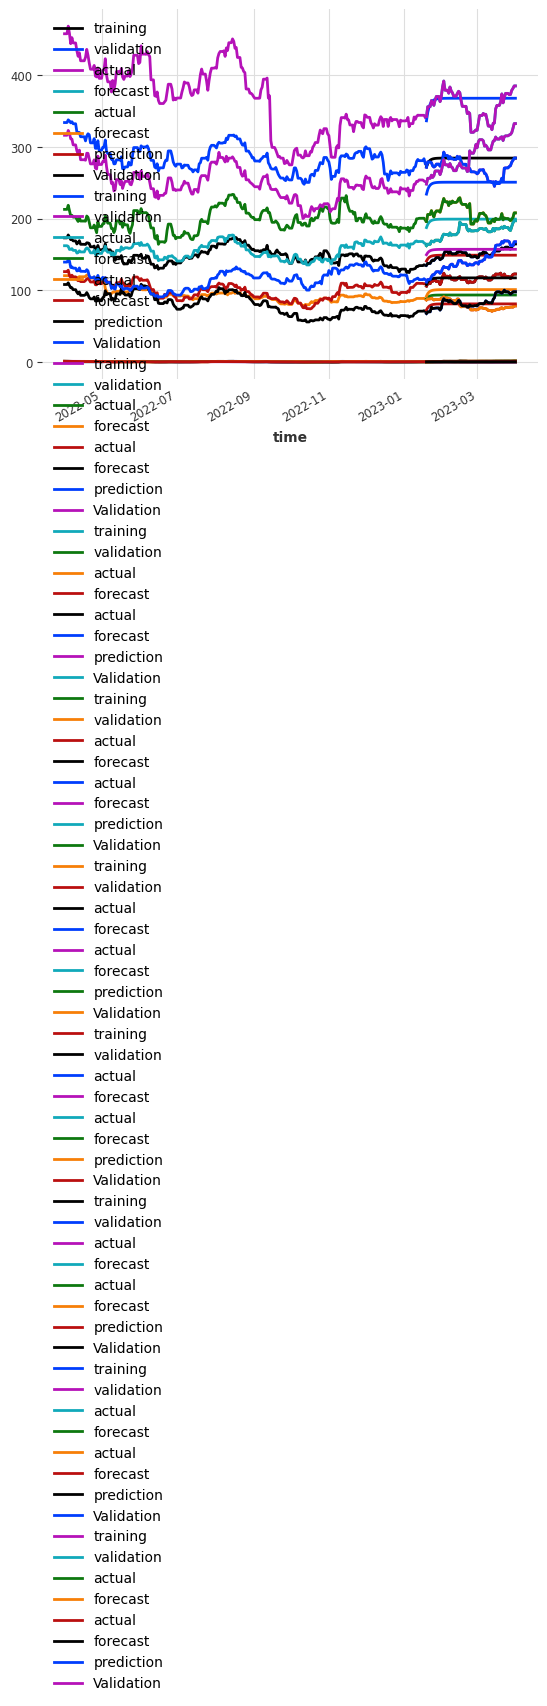

In [2]:
!pip install yfinance
!pip install darts

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
#import shutil
from sklearn.preprocessing import MinMaxScaler
#from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mse
#from darts.utils.statistics import check_seasonality, plot_acf
#from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import forecasting
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

import yfinance as yf
tickers = ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANET', 'ANSS']
for tk in tickers:
    ticker= yf.Ticker(tk)
    df = ticker.history(start="2022-04-01", end="2023-04-01", interval="1d")

    # data.reset_index(inplace=True)
    # data = data[['Date', 'Close']]

    idx = pd.date_range(start='2022-04-01', end='2023-04-01')
    df.index = pd.DatetimeIndex(df.index)
    df.index = df.index.tz_localize(None) 
    # # #df['Date'] = pd.to_datetime(df['Date'])
    # # #print(df)
    # # #df.set_index='Date'
    # # #print(df)
    # # df.index = pd.DatetimeIndex(df.index)
    # # print(df)
    df = df.reindex(idx, method = 'pad')
    print(df)
    series = TimeSeries.from_dataframe(df)
    print(series)

    adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
    training, validation = adj_series.split_after(0.8)
    training.plot(label='training')
    validation.plot(label='validation')
    plt.legend();
    from darts.dataprocessing.transformers import Scaler
    transformer = Scaler()
    train_transformed = transformer.fit_transform(training)
    val_transformed = transformer.transform(validation)
    series_transformed = transformer.transform(adj_series)
    print(train_transformed)
    print(val_transformed)
    print(series_transformed)
    # scaler_stock = Scaler()
    # series_stock_scaled = scaler_stock.fit_transform(adj_series)
    # print(series_stock_scaled)
    # training, validation = adj_series.split_after(0.8)
    my_model = RNNModel(
        model="LSTM",
        n_rnn_layers = 3,
        hidden_dim=4,
        dropout=0,
        batch_size=16,
        n_epochs=10,
        optimizer_kwargs={"lr": 1e-3},
        model_name="Air_RNN",
        log_tensorboard=True,
        random_state=42,
        training_length=20,
        input_chunk_length=3,
        force_reset=True,
        save_checkpoints=True,
    )
    my_model.fit(train_transformed)
    pred = my_model.predict(n=len(val_transformed))
    val_transformed.plot(label='actual')
    pred.plot(label='forecast')
    plt.legend();
    print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))
    series_transformed.plot(label='actual')
    pred.plot(label='forecast')
    plt.legend();
    print('MAPE = {:.2f}%'.format(mape(series_transformed, pred)))
    inverse_scaler_pred = transformer.inverse_transform(pred)

    inverse_scaler_pred.plot(label='prediction')
    validation.plot(label='Validation')
    plt.legend();

    !pip install optuna
    import optuna
    from sklearn.model_selection import cross_val_score


    def objective(trial):

        n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 5)
        hidden_dim = trial.suggest_int("hidden_dim", 1, 5)
        input_chunk_length = trial.suggest_int("input_chunk_length", 1,5)

        my_model = RNNModel(
        model="LSTM",
        n_rnn_layers = n_rnn_layers,
        hidden_dim= hidden_dim,
        input_chunk_length=input_chunk_length
        )

        my_model.fit(training)

        preds = my_model.predict(series=training, n=len(validation))
        mapes = mape(validation, preds, n_jobs=-1, verbose=True)
        smape_val = np.mean(mapes)

        return smape_val if smape_val != np.nan else float("inf")


    def print_callback(study, trial):
        print(f"Current value: {trial.value}, Current params: {trial.params}")
        print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=5, callbacks=[print_callback])


